This is for testing how the accuracy of the data changes with framenumber for 1 or 0 labels only

In [2]:
import numpy as np
import torch
import torch.nn as nn
from babel.dates import time_
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import time
import matplotlib.pyplot as plt

In [3]:
#loaded network
class SiameseNetwork(nn.Module):
	def __init__(self):
		super(SiameseNetwork,self).__init__()
		self.cnn1 = nn.Sequential(nn.Conv2d(1, 96,
											kernel_size=11, stride = 1),
								  nn.ReLU(inplace = True),
								  nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k=2),
								  nn.MaxPool2d(3, stride=2),
								  nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
								  nn.ReLU(inplace=True),nn.LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2),
								  nn.MaxPool2d(3, stride=2), nn.Dropout2d(p=0.3),
								  nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
								  nn.ReLU(inplace=True),
								  nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
								  nn.ReLU(inplace=True),
								  nn.MaxPool2d(3, stride = 2), nn.Dropout2d(p=0.3), )

		self.fc1 = nn.Sequential(nn.Linear(43264,1024), nn.ReLU(inplace=True),
								 nn.Dropout(p=0.5),
								 nn.Linear(1024, 128),
								 nn.ReLU(inplace=True),
								 nn.Linear(128, 1))
	def forward(self, img1, img2):
		x1 = self.cnn1(img1)
		x2 = self.cnn1(img2)
		x1 = x1.view(x1.size(0), -1)
		x2 = x2.view(x2.size(0), -1)
		distance = torch.abs(x1 - x2)
		score = self.fc1(distance)
		output = 1-torch.sigmoid(score)
		return output
checkpoint = torch.load(r"A:\3rd_Year_Project\Project_code\BestRun_lr0.01_bs64_epoch3000_op_class 'torch.optim.sgd.SGD'__acc63.1loss0.282.pth")
model = SiameseNetwork()
model.load_state_dict(checkpoint["model_state_dict"])
model.cuda()
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_3824\517024064.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"A:\3rd_Year_Project\Project_code\Bes

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=43264, out_features=1024, bias=True)
    (1): ReL

In [4]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
	def __init__(self, img1_dir, img2_dir, transform = None):
		self.img1_data = np.load(img1_dir)
		self.img1_images = self.img1_data['images']
		self.img1_labels = self.img1_data['labels']

		self.img2_data = np.load(img2_dir)
		self.img2_images = self.img2_data['images']
		self.img2_labels = self.img2_data['labels']
		self.transform = transform

	def __getitem__(self, index):
		random_index = np.random.choice(len(self.img1_images))
		random_num = random_index
		img1 = Image.fromarray(self.img1_images[random_num]).convert("L")
		img2 = self.img2_images[index]
		img2 = Image.fromarray(img2).convert("L")

		#if self.img1_labels[random_num] == self.img2_labels[index]:
		#	label = 0
		#else:
		#	label = 1
		label = abs(self.img1_labels[random_num] - self.img2_labels[index])

		if self.transform:
			img1 = self.transform(img1)
			img2 = self.transform(img2)
		label = torch.tensor(float(label), dtype=torch.float32).squeeze(0)
		return img1, img2, label
	def __len__(self):
		return len(self.img2_images)

In [5]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [6]:
img1_directory = "A:/3rd_Year_Project/Project_code/data/Siamese_dataset/img1.npz"
training_directory = "A:/3rd_Year_Project/Project_code/data/cropped_and_variable_labels/15VariableLabel.npz"
training_directory10 = r"A:\3rd_Year_Project\Project_code\data\Siamese_dataset\15.npz"

testing_directory = r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\2ndVariableLabel.npz"
testing_directory10 = r"A:\3rd_Year_Project\Project_code\data\Siamese_dataset\2nd.npz"

training_framenumber = np.load(r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\framenumber15.npy")
testing_framenumber = np.load(r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\framenumber2nd.npy")

In [7]:
y = np.load(training_directory)
print(y.files)
print(y["labels"].shape)

x = np.load(testing_directory)
print(x["labels"].shape)

['images', 'labels']
(12619,)
(8461,)


In [9]:
#choose which directory you want
img1_dir = img1_directory
img2_dir = testing_directory

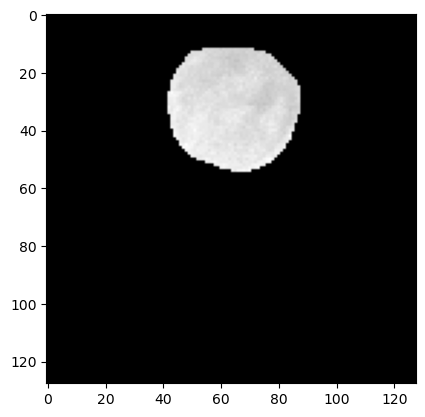

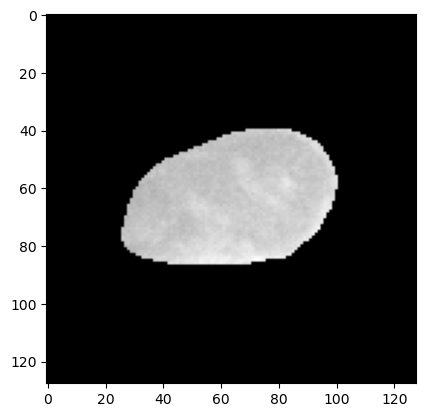

In [10]:
image_data = np.load(img2_dir)
image = image_data['images']
image1 = image[0]
image2 = image[1]
plt.imshow(image1, cmap='gray')
plt.show()
plt.imshow(image2, cmap='gray')
plt.show()
#print(np.max(image1), np.mean(image1))

In [11]:
siamese_dataset = SiameseNetworkDataset(img1_dir=img1_directory,
                                        img2_dir=img2_dir,
                                        transform=transforms.Compose(
                                            [transforms.Resize((128, 128)), transforms.ToTensor()]))
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=False,
                              num_workers=0,
                              batch_size=1,
                              pin_memory=True)

mean = []
start = time.time()
imageNo = 0
iterations = 50
all_lists = {}

for j in range(iterations):
	current_list = []
	asdfjkl = []
	for img1, img2, label in train_dataloader:
		img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
		listy = []
		with torch.no_grad():
			output = model(img1, img2)

		#predicted = int((torch.round(output*10)/10).item()*10)/10 #continuous in steps of 0.01 accuracy
		#labels = int((torch.round(label*10)/10).item()*10)/10 #continuous in steps of 0.01 accuracy

		predicted = torch.round(output).item() #binary, either 0=healthy or 1=dead
		labels = torch.round(label).item() #binary, either 0=healthy or 1=dead

		accuracy = (1-abs(predicted-labels))*100
		listy.append(accuracy)

		current_list.extend(listy)
		asdfjkl.append(accuracy)
	all_lists[j] = current_list
	mean.append(np.mean(asdfjkl))

	now = time.time()
	averageTime = (now - start)/(j+1)
	loops_left = iterations - (j+1)
	time_left = loops_left * averageTime
	hours1 = int(time_left % 86400 // 3600)
	minutes1 = int((time_left % 3600) // 60)
	seconds1 = int(time_left % 60)
	print(f"Code {(((j+1)/iterations))*100:.0f}% complete", f"ETA:{hours1}h, {minutes1} min, {seconds1} sec")
	#print(f"Average: {np.mean(asdfjkl):0f}")

print(int(np.mean(mean) * 100) / 100)

array = np.array(list(all_lists.values()))
mean_per_image = np.mean(array, axis=0)

print(f"Number of images: {len(mean_per_image)}")

Code 2% complete ETA:1h, 19 min, 35 sec
Code 4% complete ETA:1h, 18 min, 53 sec
Code 6% complete ETA:1h, 17 min, 51 sec
Code 8% complete ETA:1h, 16 min, 26 sec
Code 10% complete ETA:1h, 14 min, 28 sec
Code 12% complete ETA:1h, 12 min, 28 sec
Code 14% complete ETA:1h, 10 min, 53 sec
Code 16% complete ETA:1h, 9 min, 24 sec
Code 18% complete ETA:1h, 7 min, 54 sec
Code 20% complete ETA:1h, 6 min, 20 sec
Code 22% complete ETA:1h, 4 min, 46 sec
Code 24% complete ETA:1h, 3 min, 11 sec
Code 26% complete ETA:1h, 1 min, 35 sec
Code 28% complete ETA:0h, 59 min, 59 sec
Code 30% complete ETA:0h, 58 min, 25 sec
Code 32% complete ETA:0h, 56 min, 47 sec
Code 34% complete ETA:0h, 54 min, 58 sec
Code 36% complete ETA:0h, 53 min, 16 sec
Code 38% complete ETA:0h, 51 min, 41 sec
Code 40% complete ETA:0h, 50 min, 6 sec
Code 42% complete ETA:0h, 48 min, 29 sec
Code 44% complete ETA:0h, 46 min, 52 sec
Code 46% complete ETA:0h, 45 min, 15 sec
Code 48% complete ETA:0h, 43 min, 38 sec
Code 50% complete ETA:0h, 4

In [12]:
#FrameNumber=training_framenumber + 1 #for training data
FrameNumber=testing_framenumber + 1   #for testing data

FrameNumber = FrameNumber.tolist()
#print(len(FrameNumber), len(listy))
new_training_list = [FrameNumber, mean_per_image]
#print(new_training_list)

framey = []
meany = []
std = []
target_list = []
for i in range(len(FrameNumber)):
	if FrameNumber[i] not in framey:
		framey.append(FrameNumber[i])
		target_list = []
		for j in range(len(FrameNumber)):
			if FrameNumber[i] == FrameNumber[j]:
				target_list.append(mean_per_image[j])
		meany.append(np.mean(target_list))
		std.append(np.std(target_list))

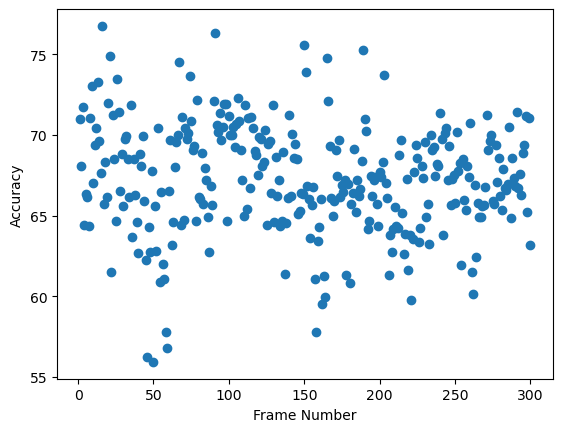

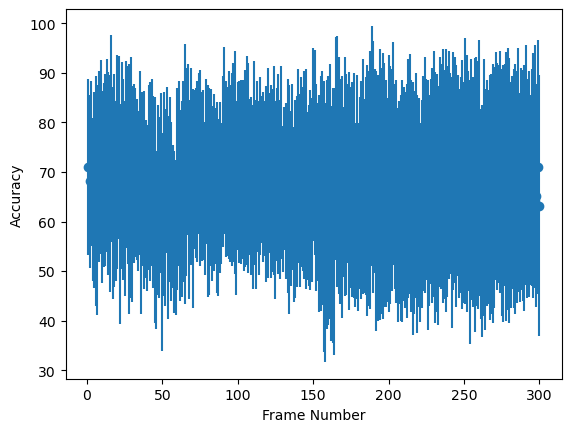

In [13]:
np.savez_compressed(r"A:\3rd_Year_Project\Project_code\data\Accuracy per frame\Acc_per_frame", frameNumber = np.array(framey), Accuracy = np.array(meany), std = np.array(std))
plt.xlabel("Frame Number")
plt.ylabel("Accuracy")
plt.scatter(framey, meany)
plt.show()
plt.errorbar(framey, meany, yerr=std)
plt.xlabel("Frame Number")
plt.ylabel("Accuracy")
plt.scatter(framey, meany)
plt.show()

In [1]:
val_dataset = SiameseNetworkDataset(img1_directory,img2_dir,
                                    transform=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()]))
validation_dataloader = DataLoader(val_dataset,shuffle = False,num_workers = 0,batch_size = 64,pin_memory = True)

class ContrastiveLoss(torch.nn.Module):
	def __init__(self):
		super(ContrastiveLoss, self).__init__()
		self.bce = nn.BCELoss()
	def forward(self, output, label):
		loss_contrastive= self.bce(output, label)
		return loss_contrastive
criterion = ContrastiveLoss()
def validate(model, validation_dataloader):
    model.eval()
    correct = 0
    total = 0
    loss_history = []
    with torch.no_grad():
        for data in validation_dataloader:
            img1, img2, label = data
            img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
            output = model(img1,img2).squeeze(1)
            loss_contrastive = criterion(output,label)
            loss_history.append(loss_contrastive.item())
            predictions = (torch.round(output * 10)/10).float()
            correct += (predictions == label).sum().item()
            total += label.size(0)
    accuracy = correct*100 / total
    avg_loss = sum(loss_history)/len(loss_history)
    return accuracy, avg_loss

accuracy, avg_loss = validate(model, validation_dataloader)
print(f"Accuracy: {accuracy:.2f}, Loss: {avg_loss:.3f}")

NameError: name 'SiameseNetworkDataset' is not defined